
# Predicting Smart Home Energy Consumption using ARIMA
## Capstone Project

## Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline


## Import

In [2]:
# data = pd.read_csv("/kaggle/input/smart-home-dataset-with-weather-information/HomeC.csv",low_memory=False)
raw_data = pd.read_csv("HomeC.csv",low_memory=False)
raw_data.info()

FileNotFoundError: [Errno 2] No such file or directory: 'HomeC.csv'

In [3]:
raw_data.head(2)

NameError: name 'raw_data' is not defined

## Check Missing value

In [ ]:
raw_data.isnull().sum()

time                   0
use [kW]               0
gen [kW]               0
House overall [kW]     0
Dishwasher [kW]        0
Furnace 1 [kW]         0
Furnace 2 [kW]         0
Home office [kW]       0
Fridge [kW]            0
Wine cellar [kW]       0
Garage door [kW]       0
Kitchen 12 [kW]        0
Kitchen 14 [kW]        0
Kitchen 38 [kW]        0
Barn [kW]              0
Well [kW]              0
Microwave [kW]         0
Living room [kW]       0
Solar [kW]             0
temperature            0
icon                   0
humidity               0
visibility             0
summary                0
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64

From the above its clear that there is  record having values NaN. Lets display that record.

In [ ]:
# display the records with NaN value in the above dataframe

raw_data[raw_data.isnull().any(axis=1)]


time  use [kW]  gen [kW]  House overall [kW]  Dishwasher [kW]  Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]  Fridge [kW]  Wine cellar [kW]  Garage door [kW]  Kitchen 12 [kW]  Kitchen 14 [kW]  Kitchen 38 [kW]  Barn [kW]  Well [kW]  Microwave [kW]  Living room [kW]  Solar [kW]  temperature                 icon  humidity  visibility summary  apparentTemperature  pressure  windSpeed cloudCover  windBearing  precipIntensity  dewPoint  precipProbability
48517  1451672917     0.742     0.003               0.742            0.000           0.478           0.062             0.041        0.005             0.007             0.012            0.001            0.000            0.000      0.031      0.001           0.004             0.002       0.003       39.930  partly-cloudy-night     0.580      10.000       P                  NaN       NaN        NaN        NaN          NaN              NaN       NaN                NaN

Now lets exclude the above record from the whole data set.

In [ ]:
data = raw_data[:-1] #delete last row  (NaNs)
data.shape
data[data.isnull().any(axis=1)]

Empty DataFrame
Columns: [time, use [kW], gen [kW], House overall [kW], Dishwasher [kW], Furnace 1 [kW], Furnace 2 [kW], Home office [kW], Fridge [kW], Wine cellar [kW], Garage door [kW], Kitchen 12 [kW], Kitchen 14 [kW], Kitchen 38 [kW], Barn [kW], Well [kW], Microwave [kW], Living room [kW], Solar [kW], temperature, icon, humidity, visibility, summary, apparentTemperature, pressure, windSpeed, cloudCover, windBearing, precipIntensity, dewPoint, precipProbability]
Index: []

## Data Preprocessing

In [ ]:
# Convert Unix timestamp to datetime, use sample frequency of minutes and make it dataframe index
data['time'] = pd.to_datetime(data['time'], unit='s')
data['time'] = pd.DatetimeIndex(pd.date_range('2016-01-01 05:00', periods=len(data),  freq='min'))
data = data.set_index('time')
data.head(2)

use [kW]  gen [kW]  House overall [kW]  Dishwasher [kW]  Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]  Fridge [kW]  Wine cellar [kW]  Garage door [kW]  Kitchen 12 [kW]  Kitchen 14 [kW]  Kitchen 38 [kW]  Barn [kW]  Well [kW]  Microwave [kW]  Living room [kW]  Solar [kW]  temperature         icon  humidity  visibility summary  apparentTemperature  pressure  windSpeed  cloudCover  windBearing  precipIntensity  dewPoint  precipProbability
time                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2016-01-01 05:00:00     0.933     0.003               0.933            0.000           0.021           0.062             0.443        0.124             0.007             0.013            0.000            0.000            0.000      0.031      0.001           0.004             0.002       0.003       36.140  clear-night     0.620      10.000   Clear               29.260  1016.910      9.180  cloudCover      282.000            0.000    24.400              0.000
2016-01-01 05:01:00     0.934     0.003               0.934            0.000           0.021           0.064             0.444        0.124             0.007             0.013            0.000            0.000            0.000      0.032      0.001           0.004             0.002       0.003       36.140  clear-night     0.620      10.000   Clear               29.260  1016.910      9.180  cloudCover      282.000            0.000    24.400              0.000

In [ ]:
data['summary'].unique()

array(['Clear', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy', 'Drizzle',
       'Light Rain', 'Rain', 'Light Snow', 'Flurries', 'Breezy'],
      dtype=object)

In [ ]:
data['cloudCover'].unique()

array(['cloudCover', '0.75', '0', '1', '0.31', '0.44', '0.13', '0.19',
       '0.25', '0.16', '0.21', '0.15', '0.14', '0.27', '0.28', '0.17',
       '0.05', '0.1', '0.26', '0.29', '0.11', '0.09', '0.12', '0.06',
       '0.02', '0.08', '0.04', '0.35', '0.22', '0.23', '0.54', '0.39',
       '0.03', '0.07', '0.76', '0.62', '0.18', '0.79', '0.48', '0.24',
       '0.57', '0.41', '0.78', '0.2', '0.77', '0.46', '0.55', '0.01',
       '0.51', '0.47', '0.5', '0.4', '0.3', '0.43', '0.33'], dtype=object)

From the above result , it seems the field `cloudCover` contains a string valur for one or more records.

### Feature Engineering

In [ ]:
fe_data = data.copy()
#Delete '[kW]' in columns name, sum similar consumtions and delete 'summary' column
fe_data.columns = [col.replace(' [kW]', '') for col in data.columns]

fe_data['Furnace'] = fe_data[['Furnace 1','Furnace 2']].sum(axis=1)
fe_data.drop(['Furnace 1','Furnace 2'], axis=1, inplace=True)

fe_data['Kitchen'] = fe_data[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1) #We could also use the mean
fe_data.drop(['Kitchen 12','Kitchen 14','Kitchen 38'], axis=1, inplace=True)

fe_data.drop(['icon','summary'], axis=1, inplace=True)

# Replace invalid values in column 'cloudCover' with backfill method
fe_data['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
fe_data['cloudCover'] = fe_data['cloudCover'].astype('float')

# Reorder columns
fe_data = fe_data[['use', 'gen', 'House overall', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar', 'Garage door', 'Barn',
             'Well', 'Microwave', 'Living room', 'Furnace', 'Kitchen', 'Solar', 'temperature', 'humidity', 'visibility',
             'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
             'dewPoint', 'precipProbability']]
fe_data.head(2)

use   gen  House overall  Dishwasher  Home office  Fridge  Wine cellar  Garage door  Barn  Well  Microwave  Living room  Furnace  Kitchen  Solar  temperature  humidity  visibility  apparentTemperature  pressure  windSpeed  cloudCover  windBearing  precipIntensity  dewPoint  precipProbability
time                                                                                                                                                                                                                                                                                                                      
2016-01-01 05:00:00 0.933 0.003          0.933       0.000        0.443   0.124        0.007        0.013 0.031 0.001      0.004        0.002    0.083    0.001  0.003       36.140     0.620      10.000               29.260  1016.910      9.180       0.750      282.000            0.000    24.400              0.000
2016-01-01 05:01:00 0.934 0.003          0.934       0.000        0.444   0.124        0.007        0.013 0.032 0.001      0.004        0.002    0.085    0.001  0.003       36.140     0.620      10.000               29.260  1016.910      9.180       0.750      282.000            0.000    24.400              0.000

## Energy correlations

['use', 'gen', 'House overall', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar', 'Garage door', 'Barn', 'Well', 'Microwave', 'Living room', 'Furnace', 'Kitchen', 'Solar']


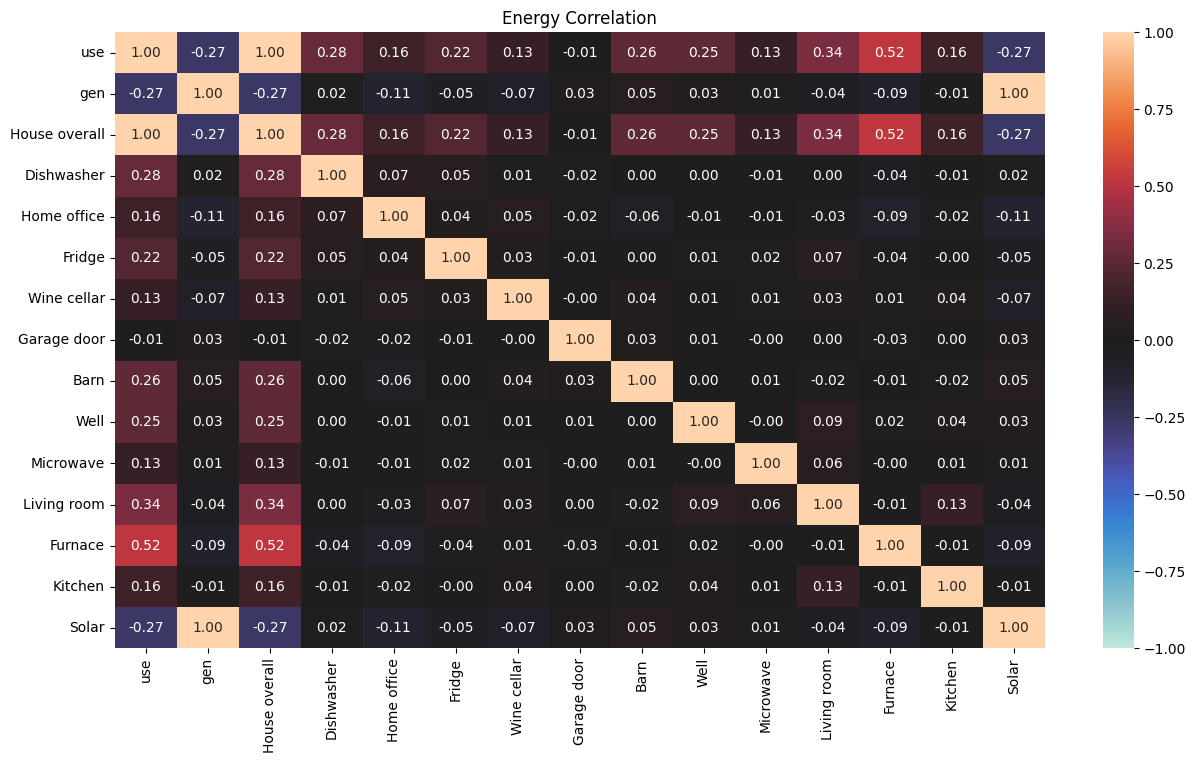

In [ ]:
# fe_data.reset_index(inplace=True)
print(fe_data.columns[0:15].tolist())
# fe_data[fe_data.columns[0:15].tolist()].head(2)
#Checking Correlations (Only Energy features)
fig = plt.subplots(figsize=(15, 8))
sns.heatmap(fe_data[fe_data.columns[0:15].tolist()].corr(), annot=True, fmt='.2f', vmin=-1.0, vmax=1.0, center=0)
plt.title('Energy Correlation', fontsize=12);

In [ ]:
# From the above corelation graph, some columns look so much correlated that they might be the same data
# Example: gen,  Solar, use, House Overall
print(fe_data['gen'].equals(fe_data['Solar']))
print(fe_data['use'].equals(fe_data['House overall']))
#'True' if all elements in the columns coincide

True
True


<Axes: xlabel='time'>

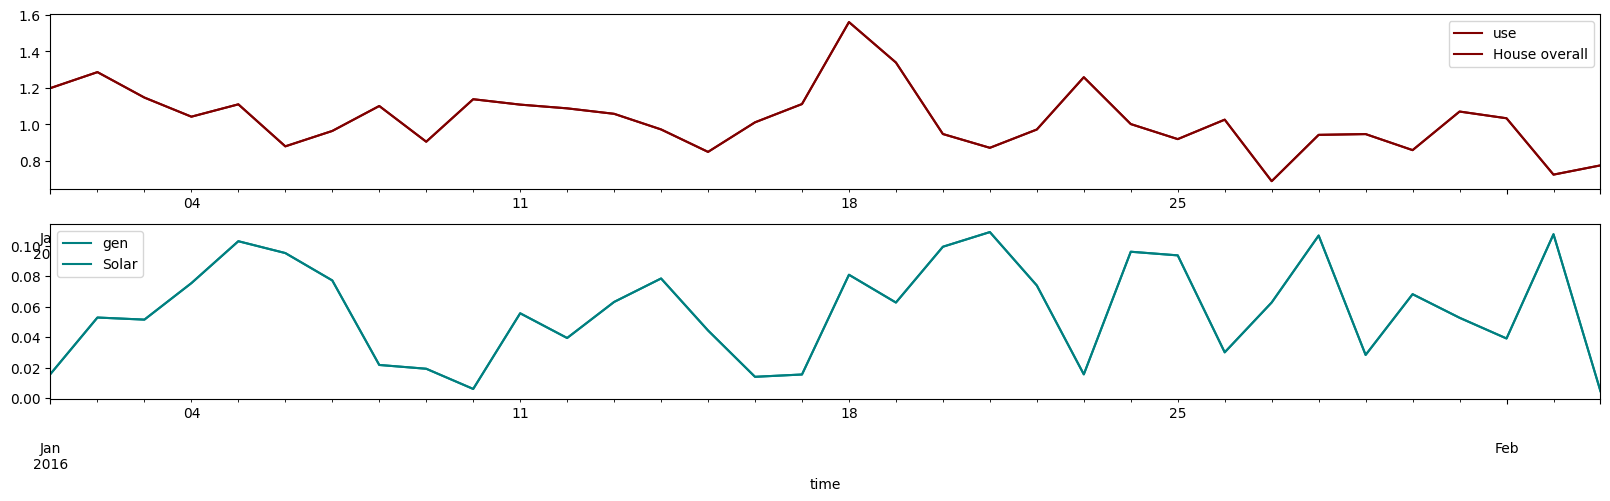

In [ ]:
# Hmmm.. They are indeed the same data (overlaping perfectly)
# Meaning, we need to resample the columns and plot the mean values
fig, axes = plt.subplots(2,1, figsize=(20,5))
fe_data[['use','House overall']].resample('D').mean().plot(ax=axes[0], color='maroon')
fe_data[['gen','Solar']].resample('D').mean().plot(ax=axes[1], color='teal')

In [ ]:
# Drop the duplicate ones
fe_data.drop(['House overall', 'Solar'], axis=1, inplace=True)

## Check the Weather correlations

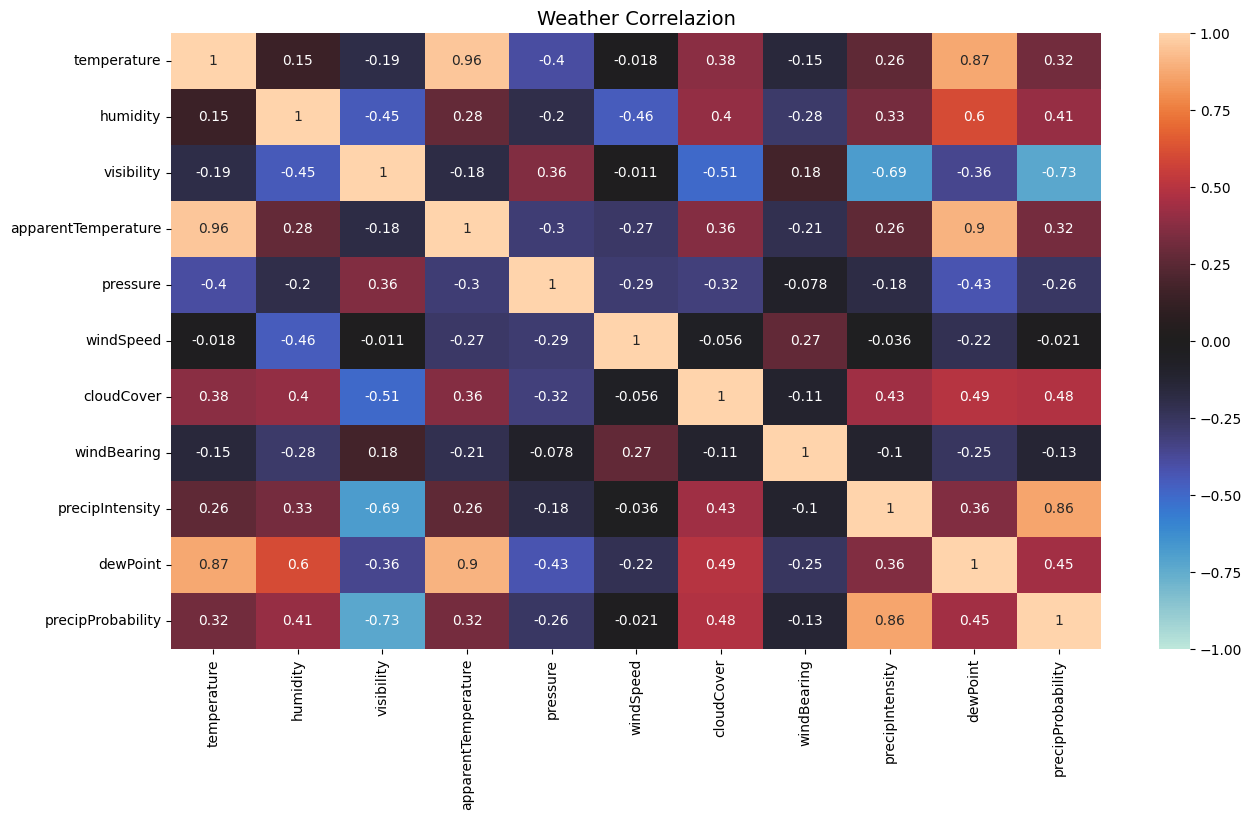

In [ ]:
#Checking Correlations (only weather features)
fig = plt.subplots(figsize=(15, 8))
sns.heatmap(fe_data[fe_data.columns[13:].tolist()].corr(), annot=True, vmin=-1.0, vmax=1.0, center=0)
plt.title('Weather Correlazion', fontsize=14);

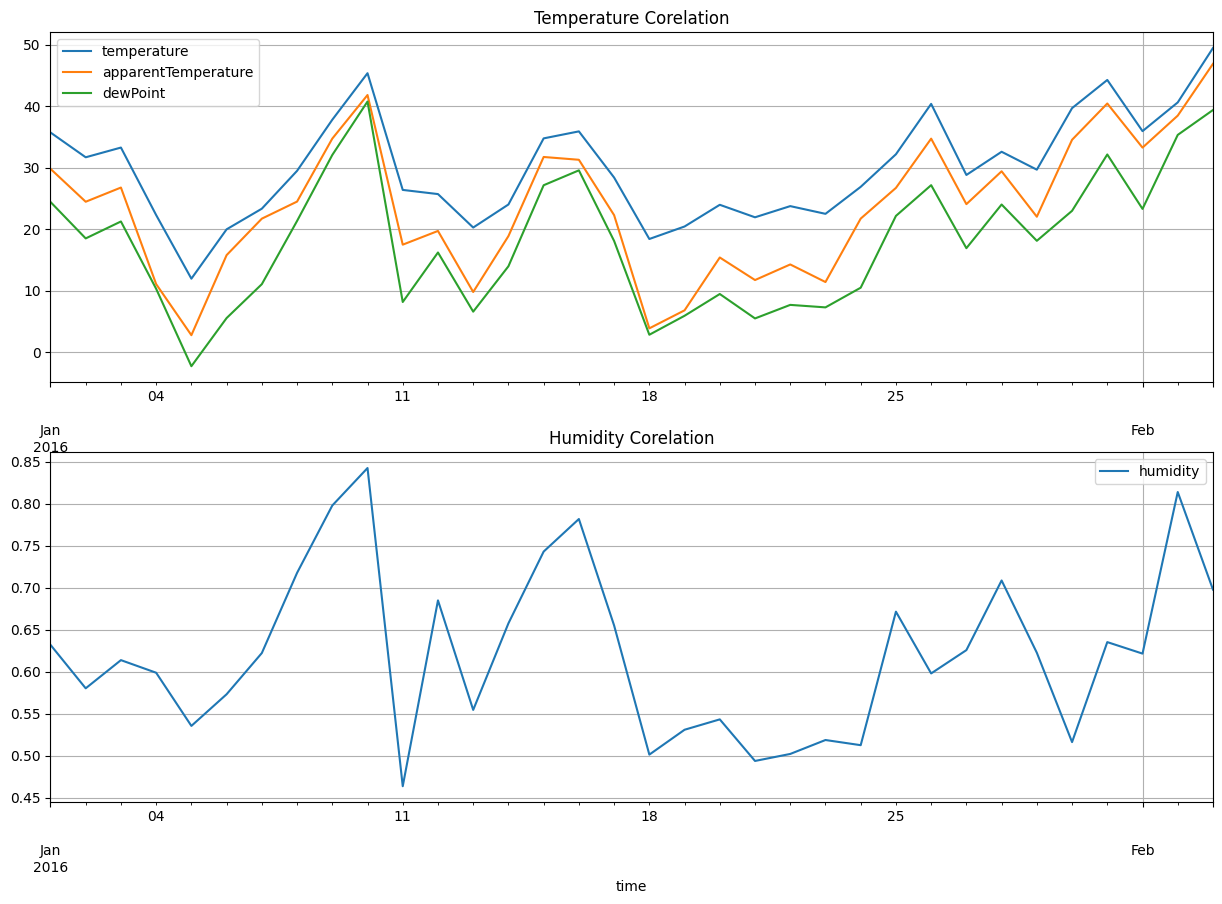

In [ ]:
# Seems a few correlations found in the weather data, lets check
fig, axes = plt.subplots(2,1, figsize=(15,10))
fe_data[['temperature','apparentTemperature', 'dewPoint']].resample('D').mean().plot(ax=axes[0], grid=True).title.set_text('Temperature Corelation')
fe_data[['humidity']].resample('D').mean().plot(ax=axes[1], grid=True).title.set_text('Humidity Corelation')

#### Temperature Corelation check w/ Weather Columns

In [ ]:
# Check correlations between diff(apparentTemperature, temperature) and other weather columns
fe_data['Tdiff'] = (fe_data['apparentTemperature']-fe_data['temperature'])
clima = fe_data.columns[13:-1].tolist()
lista_corr = []
for i in clima:
  cor = fe_data[i].corr(fe_data['Tdiff'])
  lista_corr.append(cor)
fe_data_corr = pd.DataFrame(list(zip(clima, lista_corr)), columns=['weather','Tdiff_corr']).set_index('weather')
fe_data_corr

Tdiff_corr
weather                        
temperature               0.486
humidity                  0.497
visibility               -0.092
apparentTemperature       0.713
pressure                  0.052
windSpeed                -0.789
cloudCover                0.195
windBearing              -0.289
precipIntensity           0.162
dewPoint                  0.615
precipProbability         0.205

<Axes: xlabel='time'>

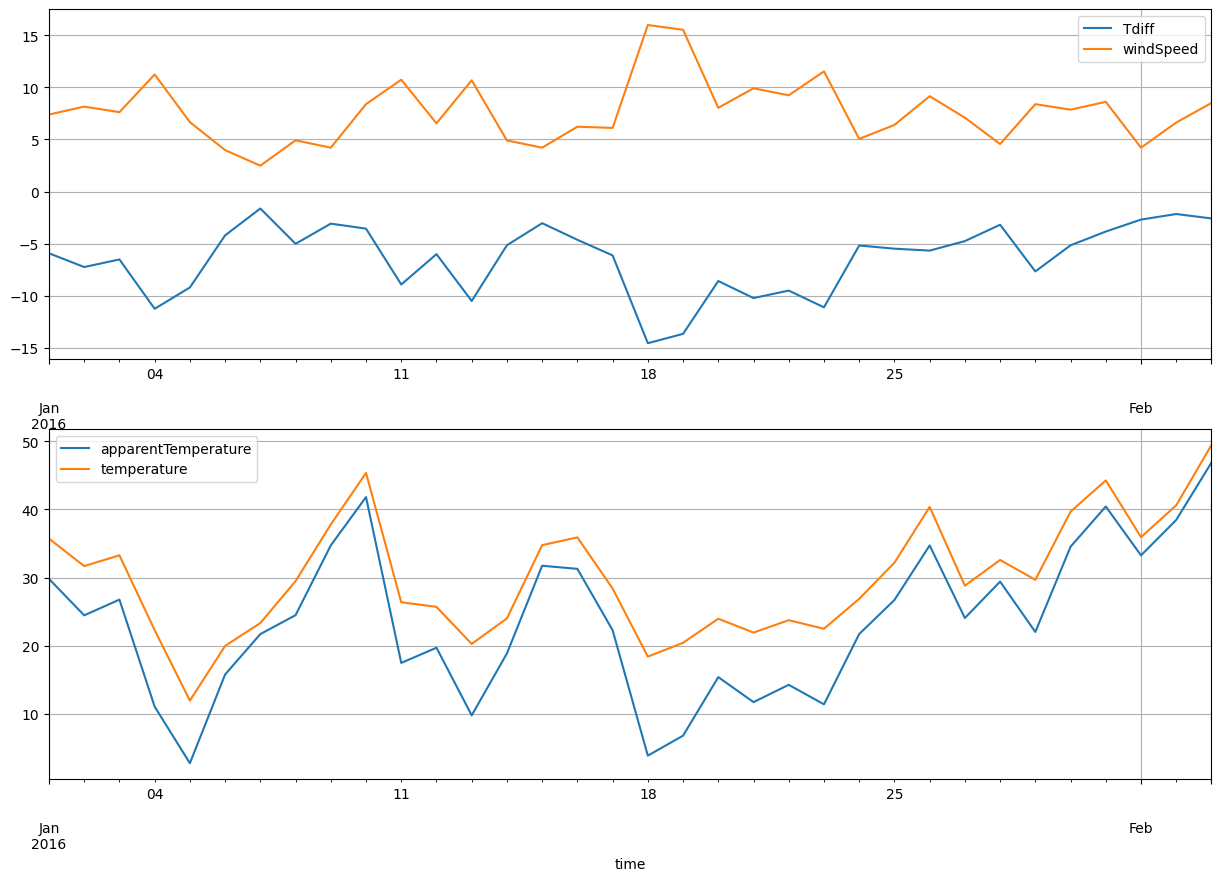

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(15,10))
fe_data[['Tdiff','windSpeed']].resample('D').mean().plot(ax=axes[0], grid=True)
fe_data[['apparentTemperature', 'temperature']].resample('D').mean().plot(ax=axes[1], grid=True)

In [ ]:
# Its clear that the tempeture difference and the Windspeed are not same so we dont need the diff column, hence drop it.
fe_data.drop('Tdiff', axis=1, inplace=True)


In [ ]:
fe_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48517 entries, 2016-01-01 05:00:00 to 2016-02-03 21:36:00
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   use                  48517 non-null  float64
 1   gen                  48517 non-null  float64
 2   Dishwasher           48517 non-null  float64
 3   Home office          48517 non-null  float64
 4   Fridge               48517 non-null  float64
 5   Wine cellar          48517 non-null  float64
 6   Garage door          48517 non-null  float64
 7   Barn                 48517 non-null  float64
 8   Well                 48517 non-null  float64
 9   Microwave            48517 non-null  float64
 10  Living room          48517 non-null  float64
 11  Furnace              48517 non-null  float64
 12  Kitchen              48517 non-null  float64
 13  temperature          48517 non-null  float64
 14  humidity             48517 non-null  float64
 15  v

## Data Visualizations

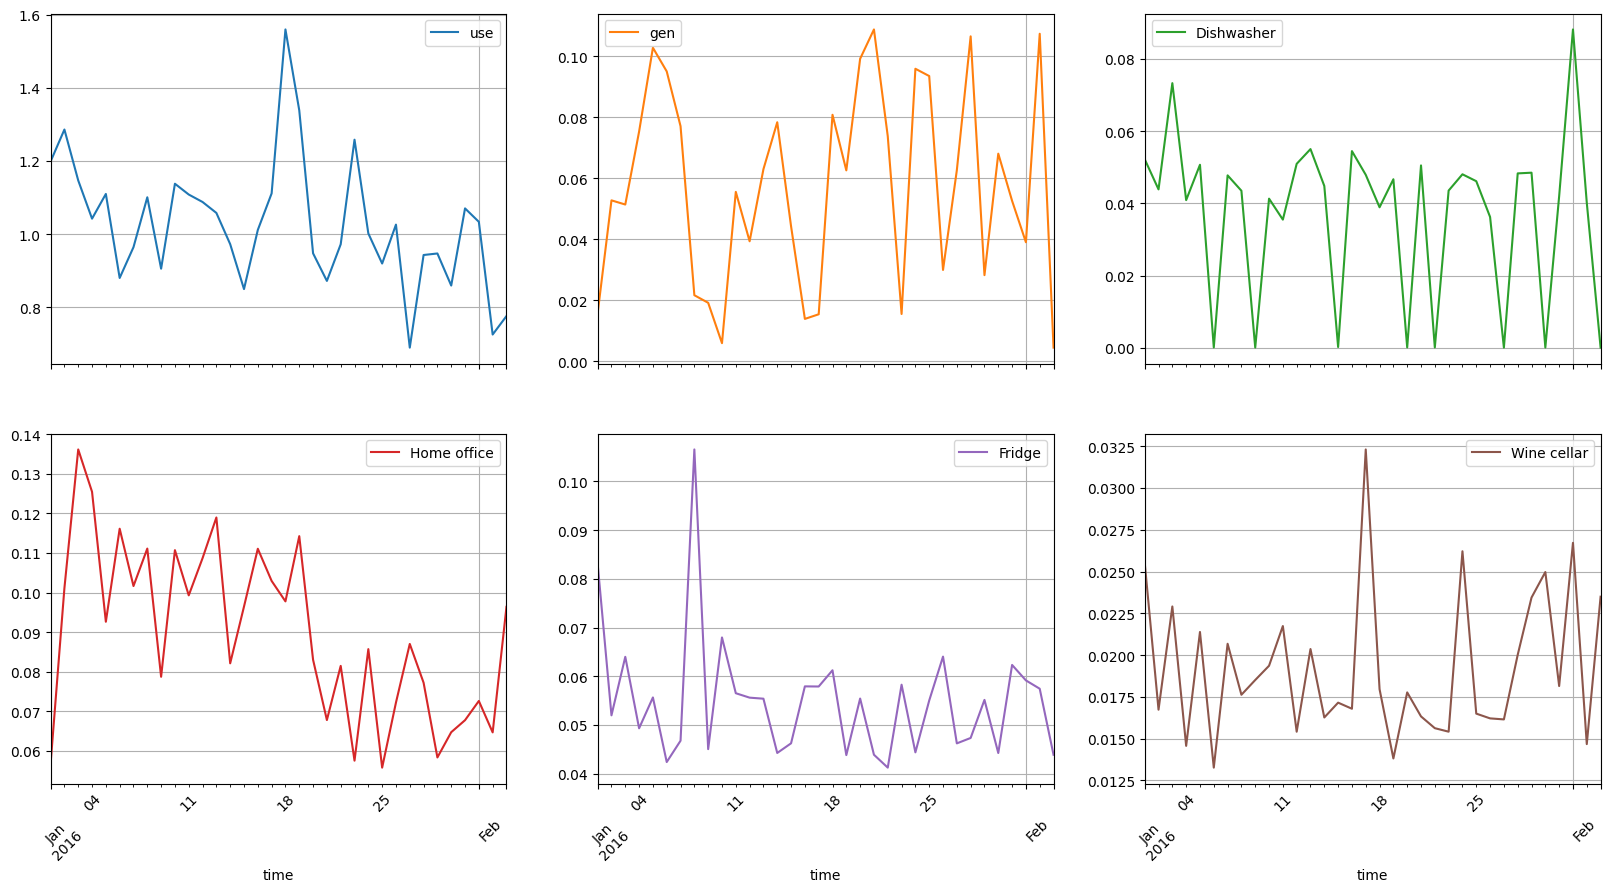

In [ ]:
#First 6 Energy columns (resample by day (rule=D or 1440Min))
fe_data[fe_data.columns[0:6].tolist()].resample("D").mean().plot(
    subplots=True, layout=(-1, 3), figsize=(20, 10), grid=True, rot=45);

array([[<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>]], dtype=object)

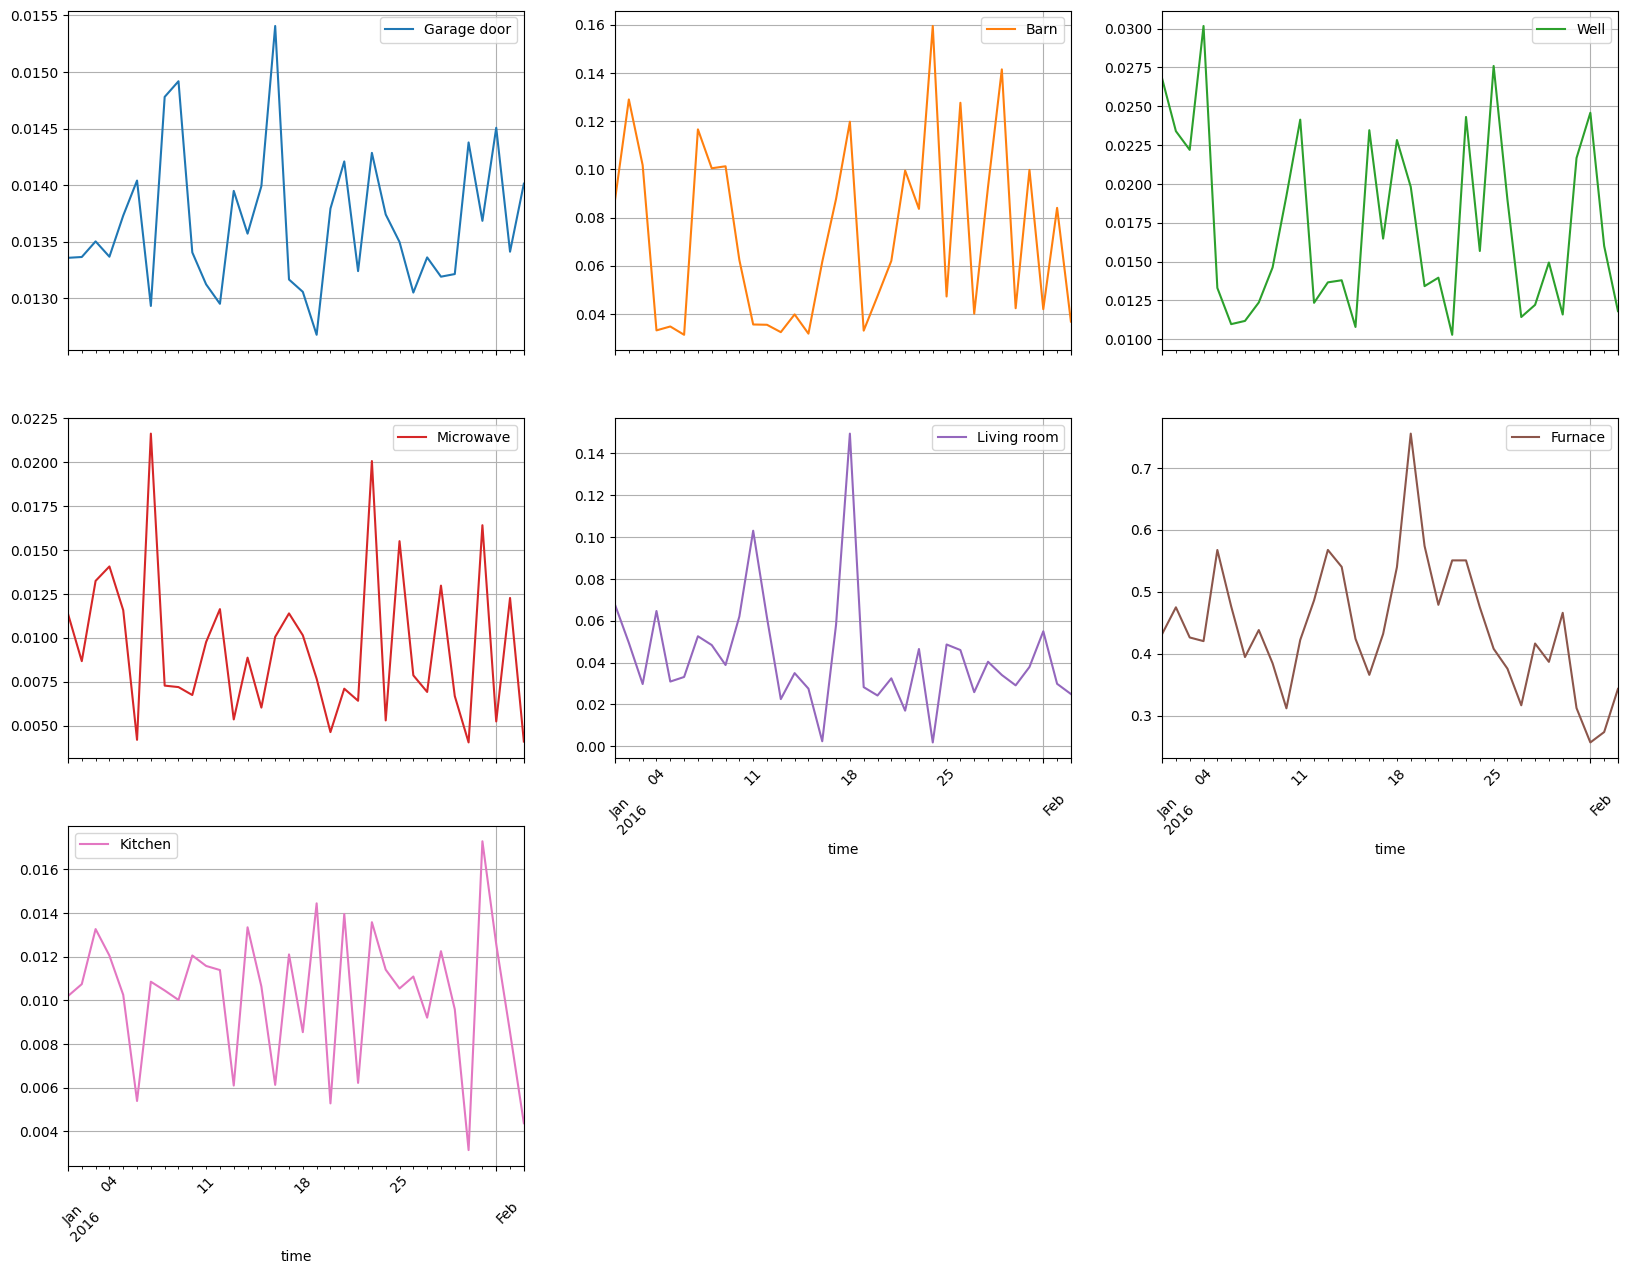

In [ ]:
# Rest of Energy columns
fe_data[fe_data.columns[6:13].tolist()].resample("D").mean().plot(
    subplots=True, layout=(-1, 3), figsize=(20, 15), grid=True, rot=45)

array([[<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>],
       [<Axes: xlabel='time'>, <Axes: xlabel='time'>,
        <Axes: xlabel='time'>]], dtype=object)

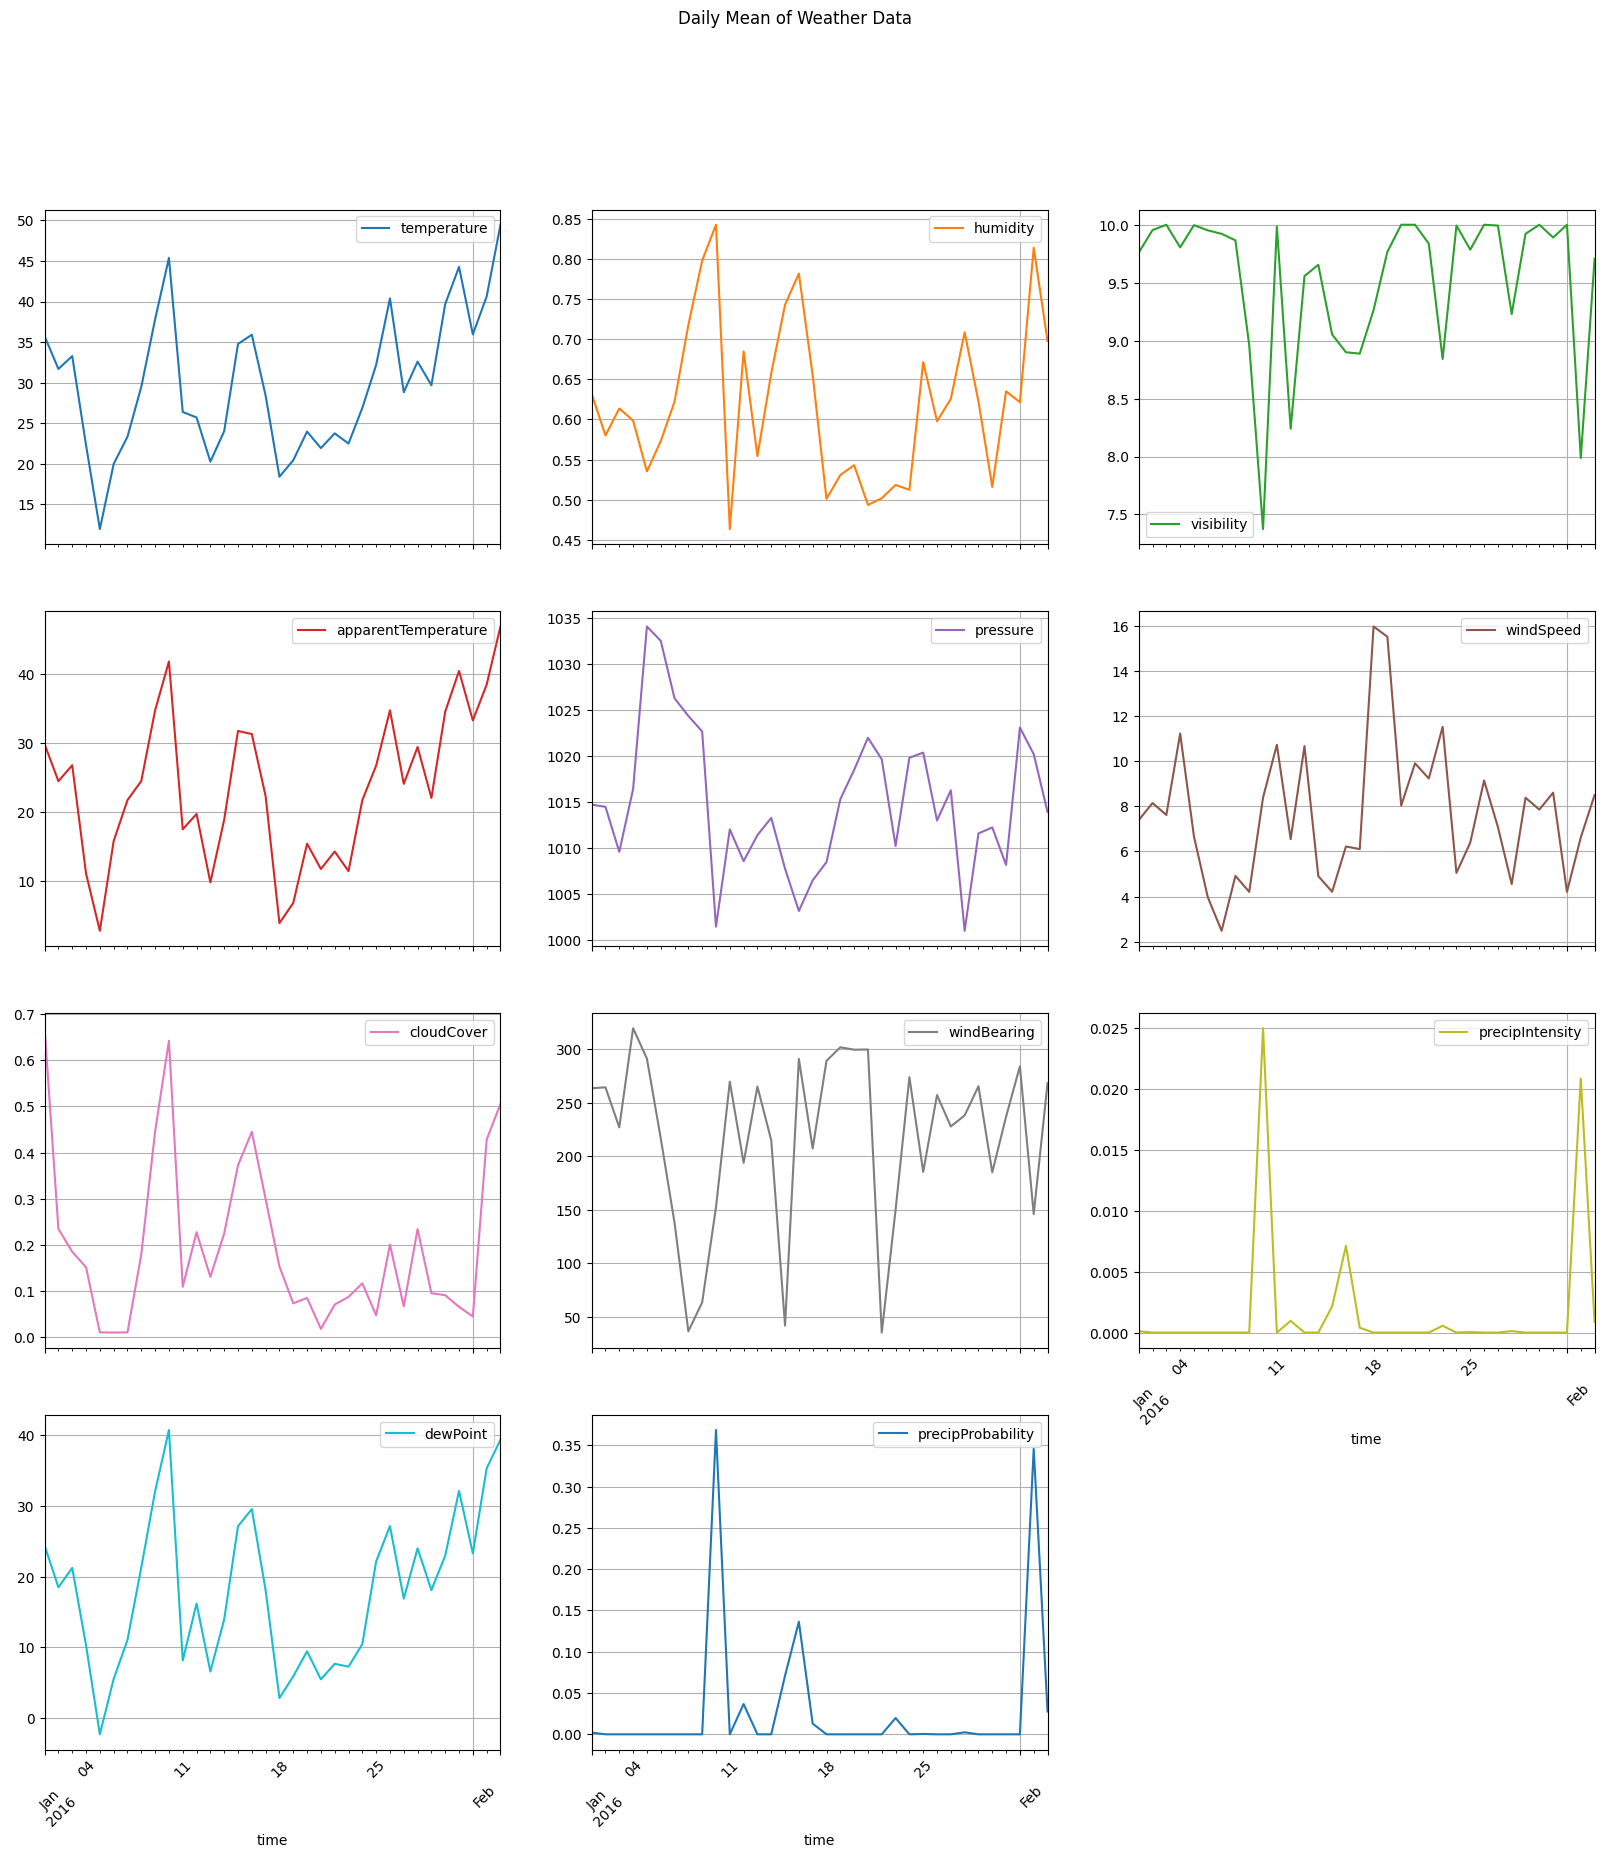

In [ ]:
# Lets visualize wheather data
fe_data[fe_data.columns[13:].tolist()].resample("D").mean().plot(
    subplots=True, layout=(-1, 3), figsize=(20, 20), grid=True, rot=45, title='Daily Mean of Weather Data')

### Groupings by Date time components

In [ ]:
ts_data = fe_data.copy()

# Define new columns from datetime field
ts_data['month'] = ts_data.index.month
ts_data['day'] = ts_data.index.day
ts_data['weekday'] = ts_data.index.day_name()
ts_data['hour'] = ts_data.index.hour
ts_data['minute'] = ts_data.index.minute
ts_data.head(2)

use   gen  Dishwasher  Home office  Fridge  Wine cellar  Garage door  Barn  Well  Microwave  Living room  Furnace  Kitchen  temperature  humidity  visibility  apparentTemperature  pressure  windSpeed  cloudCover  windBearing  precipIntensity  dewPoint  precipProbability  month  day weekday  hour  minute
time                                                                                                                                                                                                                                                                                                                                  
2016-01-01 05:00:00 0.933 0.003       0.000        0.443   0.124        0.007        0.013 0.031 0.001      0.004        0.002    0.083    0.001       36.140     0.620      10.000               29.260  1016.910      9.180       0.750      282.000            0.000    24.400              0.000      1    1  Friday     5       0
2016-01-01 05:01:00 0.934 0.003       0.000        0.444   0.124        0.007        0.013 0.032 0.001      0.004        0.002    0.085    0.001       36.140     0.620      10.000               29.260  1016.910      9.180       0.750      282.000            0.000    24.400              0.000      1    1  Friday     5       1

### Consumption Analysis by Month

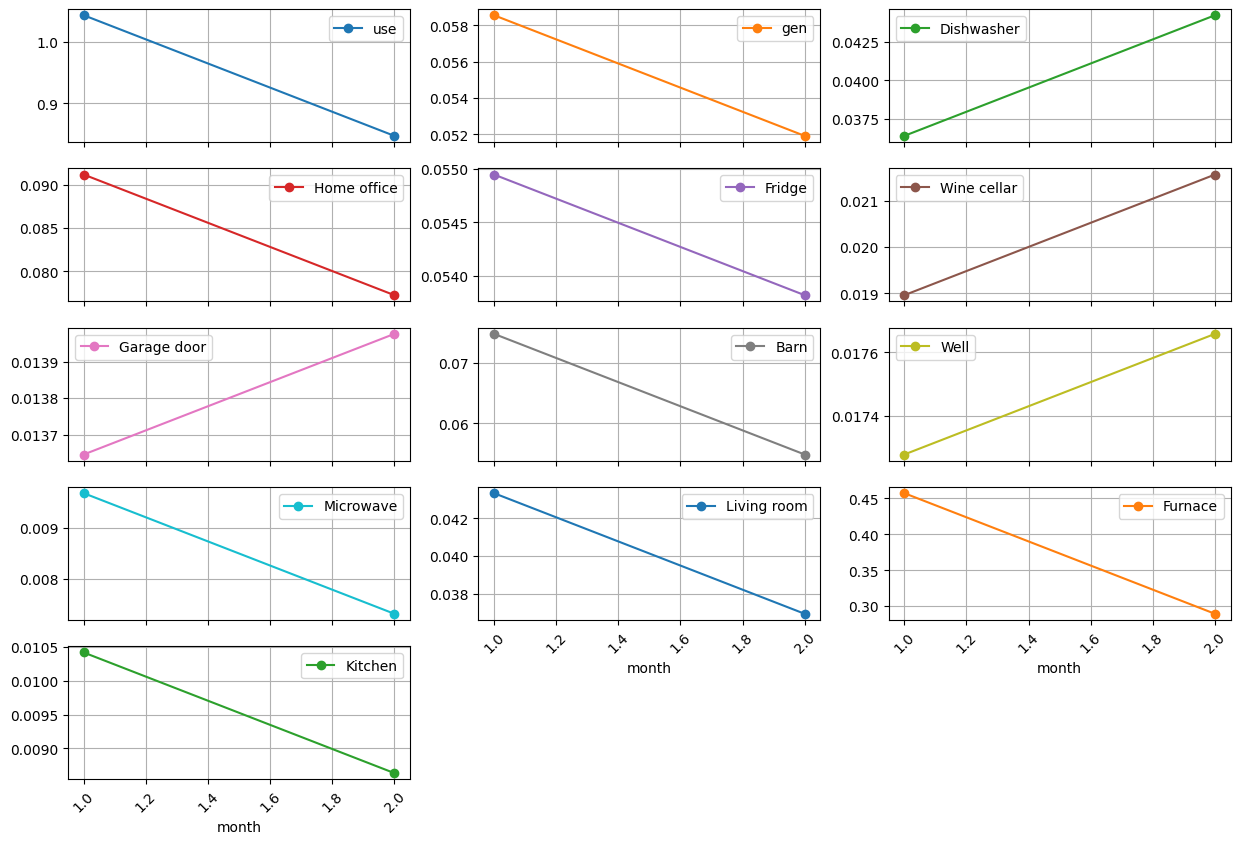

In [ ]:
## Averge consumption per month
mean_month = ts_data.groupby('month').agg({i:'mean' for i in ts_data.columns[:-5].tolist()})
mean_month[mean_month.columns[0:13].tolist()].plot(
    subplots=True, layout=(-1, 3), figsize=(15, 10), grid=True, rot=45, xlabel=None, marker='o');

### Consumption Analysis in Weekday

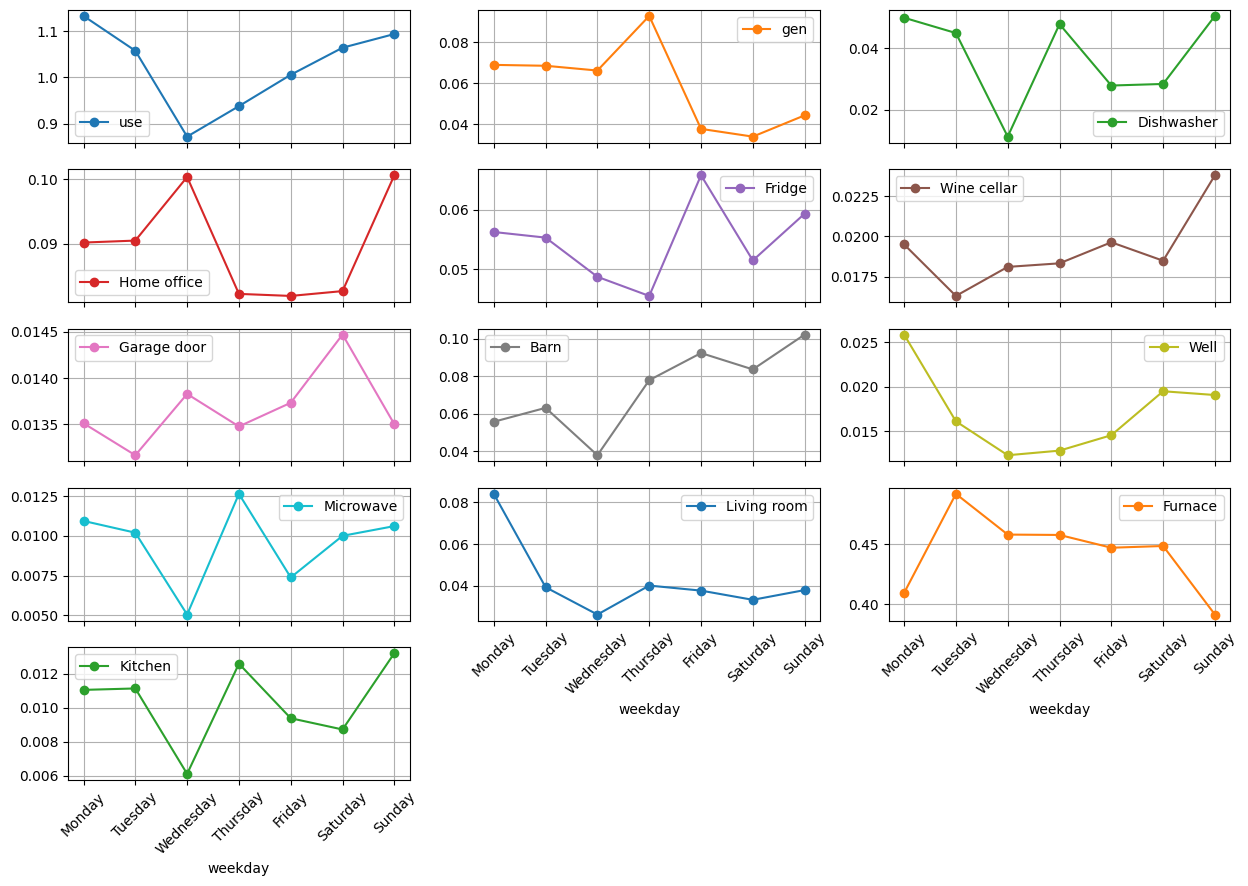

In [ ]:
# Averge consumption per day of the week
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_weekday = ts_data.groupby('weekday').agg({i:'mean' for i in ts_data.columns[:-5].tolist()}).reindex(days)

mean_weekday[mean_weekday.columns[0:13].tolist()].plot(
    subplots=True, layout=(-1, 3), figsize=(15, 10), grid=True, rot=45, xlabel=None, marker='o');

### Consumption Analysis by Hours

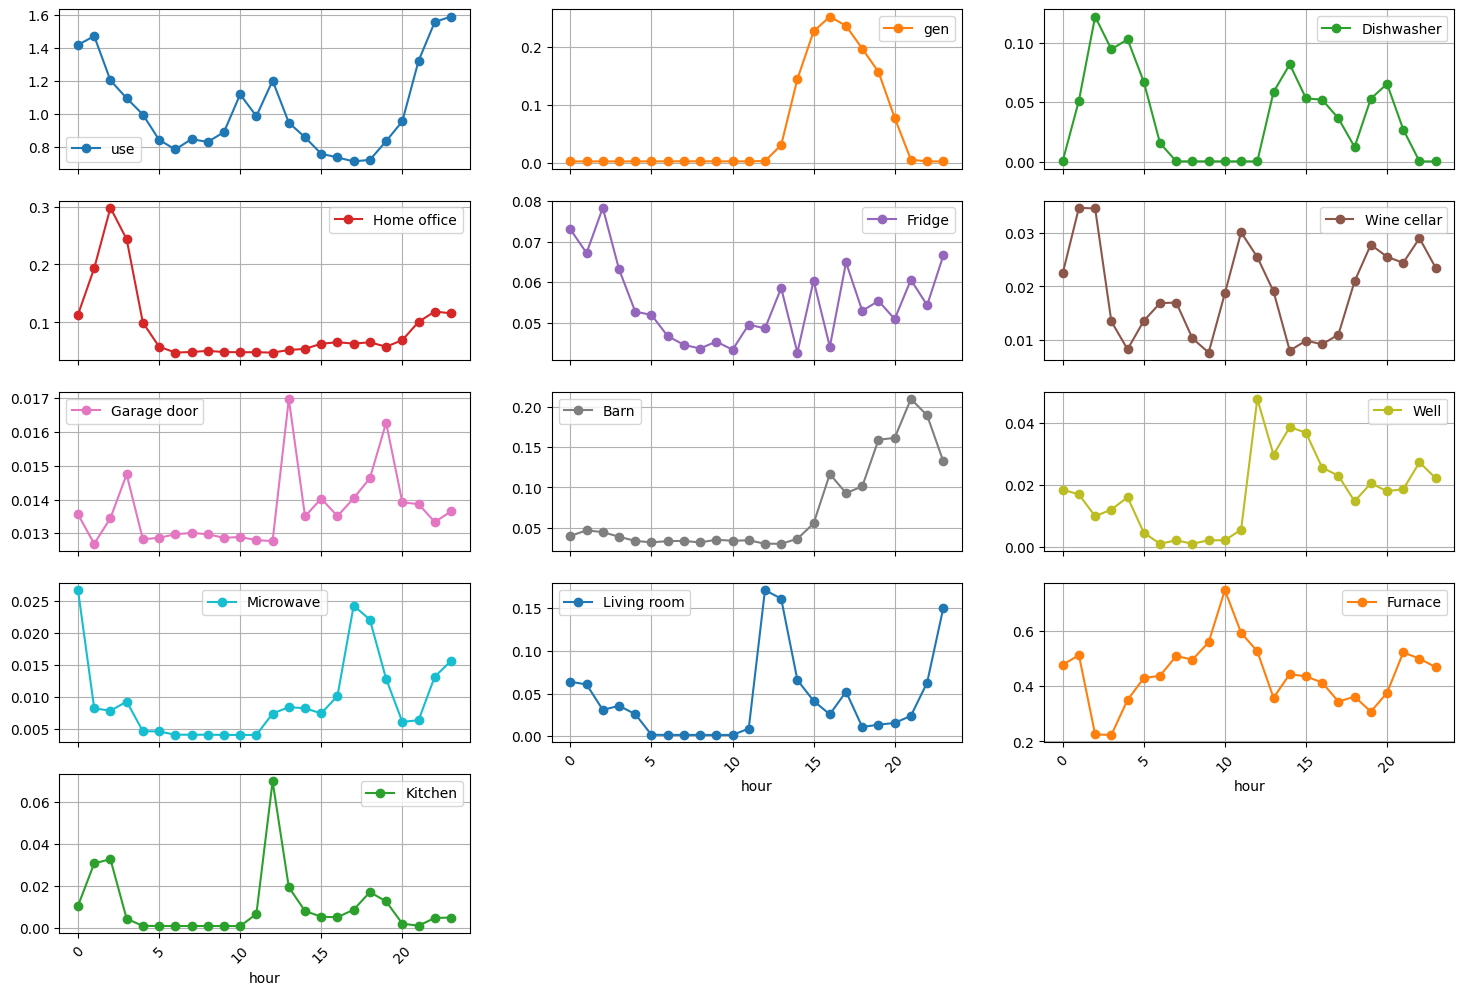

In [ ]:
# Averge consumption per hour of the day
mean_hour = ts_data.groupby('hour').agg({i:'mean' for i in ts_data.columns[:-5].tolist()})

mean_hour[mean_hour.columns[0:13].tolist()].plot(
    subplots=True, layout=(-1, 3), figsize=(18, 12), grid=True, rot=45, xlabel=None, marker='o');

## Energy vs. Weather Correlations

In [ ]:
consumtions = ts_data.columns[0:13].tolist()
weather = ts_data.columns[13:-5].tolist()
lists = [consumtions,]
for j in weather:
    correlations = []
    for i in consumtions:
        cor = ts_data[i].corr(ts_data[j])
        correlations.append(cor)
    lists.append(correlations)

names=['consumtions']
for i in weather:
    names.append(i+'_corr')
dataframe_corr = pd.DataFrame(np.column_stack(lists), columns=names).set_index('consumtions')

for i in dataframe_corr.columns[:].tolist():
    dataframe_corr[i] = dataframe_corr[i].apply(float)

In [ ]:
# Highlight correlations between energy and weather (red for corr > 0.1, orange for corr < -0.1)
dataframe_corr.style.applymap(lambda x: "background-color: maroon" if x > 0.1
                              else "background-color: orange" if x < -0.1
                              else "background-color: grey")

### Additional feature exploration

In [ ]:
# Check whether Usage corresponds to the sum of other comsumpitons (it seems not)
ts_data['Sum_usage'] = ts_data[list(ts_data.columns[1:12])].sum(axis=1)
ts_data['Usage_diff'] = ts_data['use'] - ts_data['Sum_usage']
ts_data.head(2)

use   gen  Dishwasher  Home office  Fridge  Wine cellar  Garage door  Barn  Well  Microwave  Living room  Furnace  Kitchen  temperature  humidity  visibility  apparentTemperature  pressure  windSpeed  cloudCover  windBearing  precipIntensity  dewPoint  precipProbability  month  day weekday  hour  minute  Sum_usage  Usage_diff
time                                                                                                                                                                                                                                                                                                                                                         
2016-01-01 05:00:00 0.933 0.003       0.000        0.443   0.124        0.007        0.013 0.031 0.001      0.004        0.002    0.083    0.001       36.140     0.620      10.000               29.260  1016.910      9.180       0.750      282.000            0.000    24.400              0.000      1    1  Friday     5       0      0.711       0.222
2016-01-01 05:01:00 0.934 0.003       0.000        0.444   0.124        0.007        0.013 0.032 0.001      0.004        0.002    0.085    0.001       36.140     0.620      10.000               29.260  1016.910      9.180       0.750      282.000            0.000    24.400              0.000      1    1  Friday     5       1      0.714       0.220

Text(0.5, 1.0, 'Usage difference')

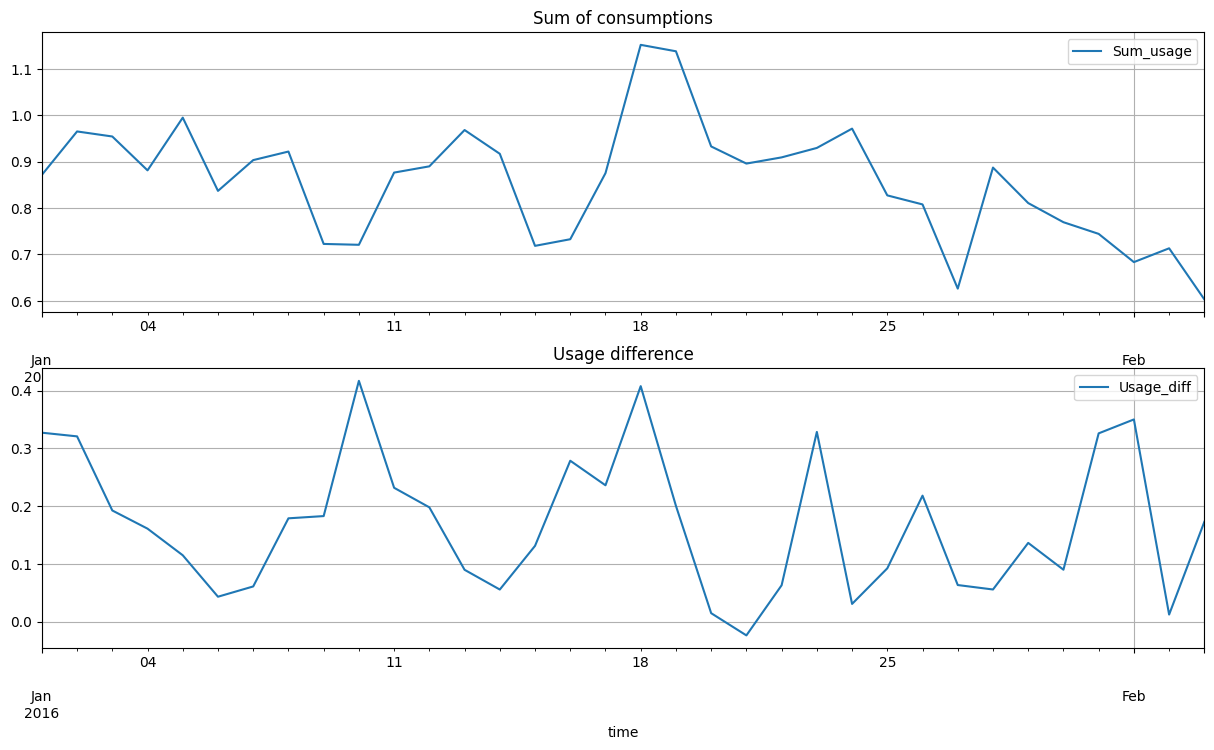

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(15,8))
ts_data['Sum_usage'].resample('D').mean().plot(ax=axes[0], grid=True, legend=True).set_title('Sum of consumptions')
ts_data['Usage_diff'].resample('D').mean().plot(ax=axes[1], grid=True, legend=True).set_title('Usage difference')

## Baseline model

#### Moving Average
Let's take the moving average as a baseline model for reference:

$$\hat{y}_t = \frac 1n\sum_{i=1}^n(y_{t-i})$$

to get an RMSE threshold to beat

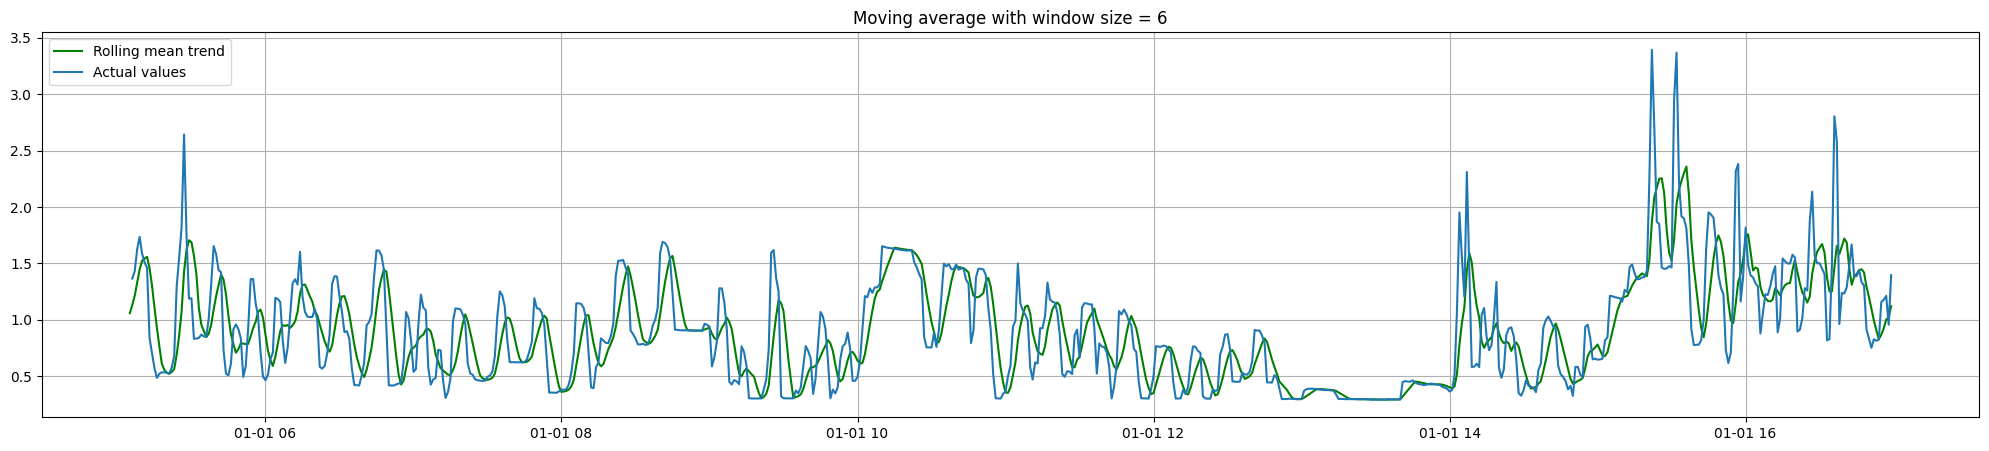

In [ ]:
model_data = ts_data.copy()


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(25,5))
    plt.title("Moving average with window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

n_samples = 24*30 # 1 month
cols = ['use']
plotMovingAverage(model_data[cols][:n_samples], window=6) # A window of 6 hours


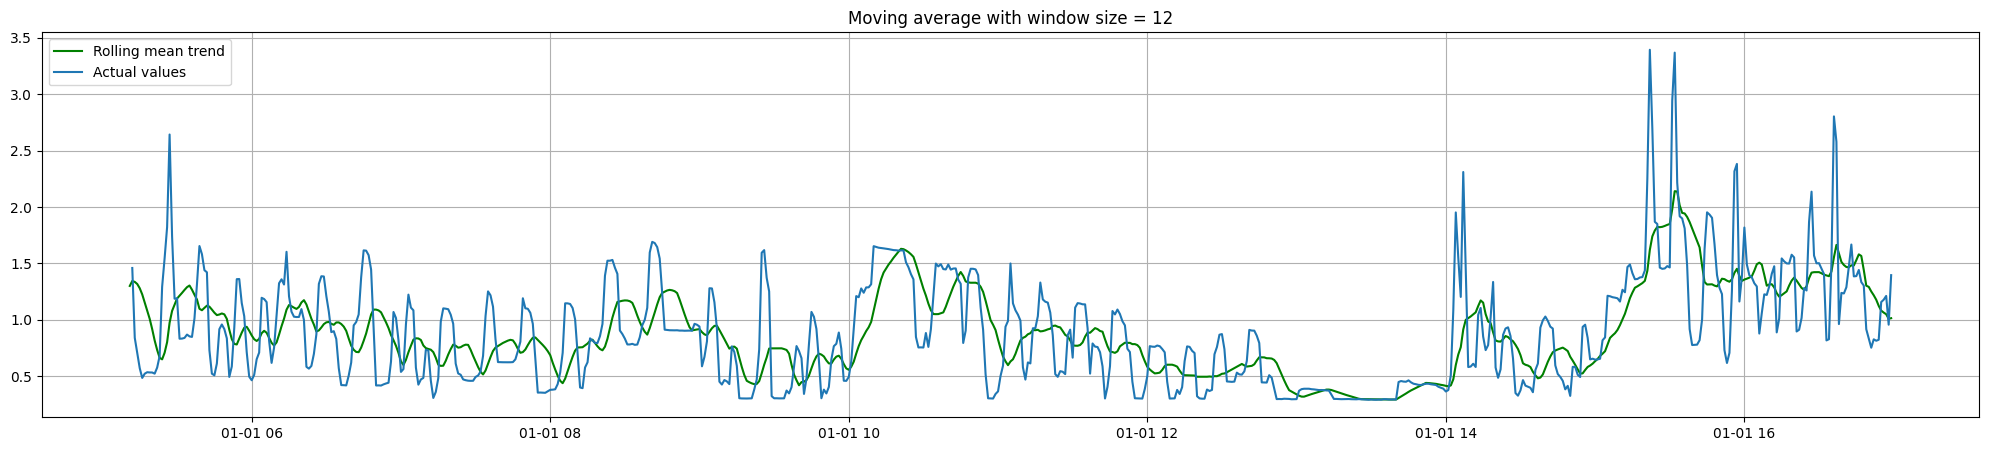

In [ ]:
plotMovingAverage(model_data[cols][:n_samples], window=12) # A window of 12 hours

## Anomaly Detection

> Spotting the Unusual: Using Moving Averages to Find Anomalies in Time Series

A basic approach to detect anomalies in time series data involves using a moving average to represent the underlying trend. Points that deviate significantly from this moving average are then flagged as potential anomalies.

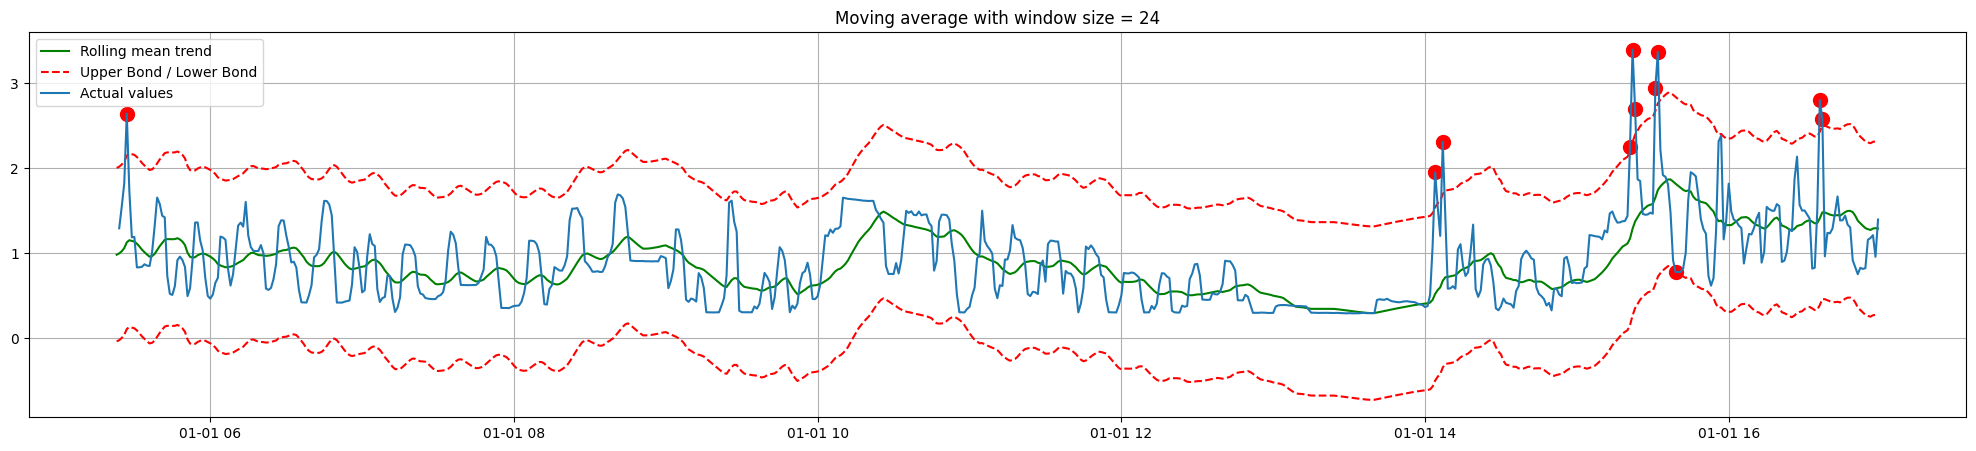

In [ ]:
plotMovingAverage(model_data[cols][:n_samples], window=24, plot_intervals=True, plot_anomalies=True)

## Exponential smoothing
> Exponential smoothing is a popular technique for forecasting time series data. It's relatively simple to understand and implement, making it a go-to method for various forecasting tasks.

> Exponential smoothing is a valuable tool for time series forecasting, offering a balance between simplicity and effectiveness. By understanding its core concepts, types, and considerations, you can determine if it's a suitable approach for your forecasting needs.


𝑦̂ 𝑡=𝛼⋅𝑦𝑡+(1−𝛼)⋅𝑦̂ 𝑡−1

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(25, 5))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

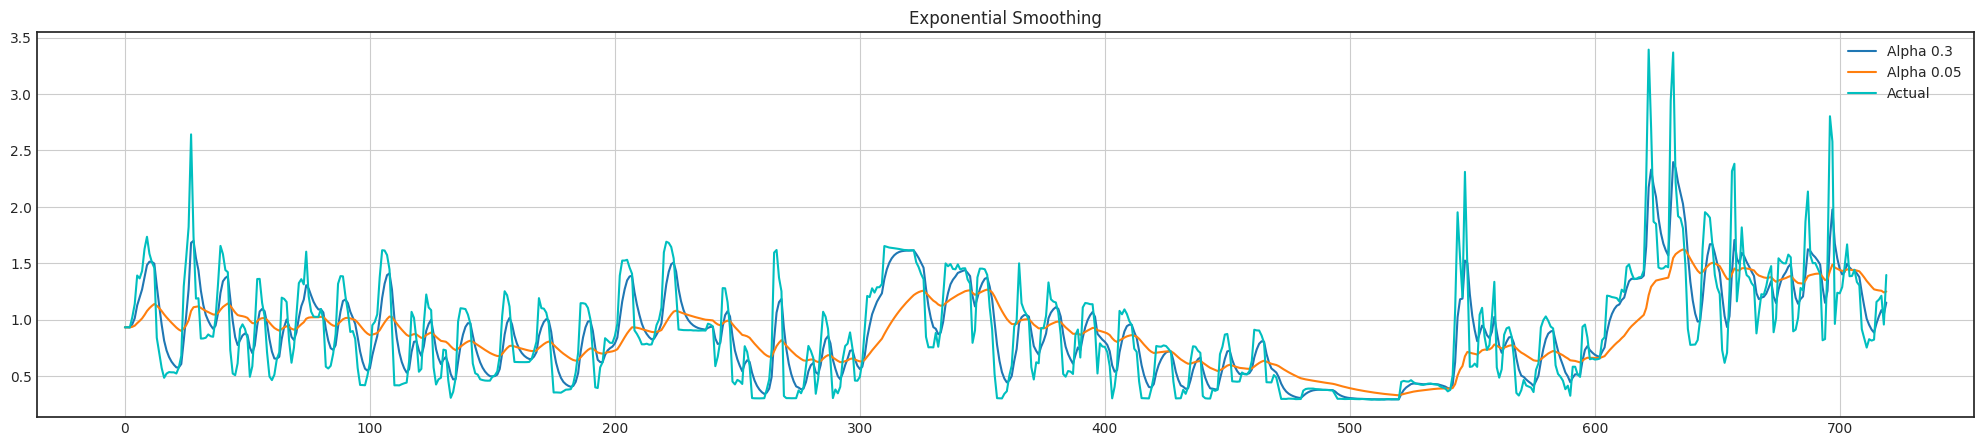

In [ ]:
n_samples = 24*30 # 1 month
col = 'use'
plotExponentialSmoothing(model_data[col][:n_samples], [0.3, 0.05])

## Stationarity check
Before using ARIMA models, it's crucial to ensure the time series data is stationary. Stationarity means the statistical properties (like average and variance) remain constant over time.

The `Augmented Dickey-Fuller (ADF) test` is a common tool to assess stationarity. It talks about:

> `Null Hypothesis`: The ADF test assumes the data is non-stationary (this is the null hypothesis).

> `P-value and Rejection`: If the p-value of the test is less than the chosen significance level (often 0.05), we reject the null hypothesis. This suggests the data likely is stationary.

> `Critical Values`: The ADF test also provides critical values at different confidence levels (1%, 5%, 10%). These values represent thresholds for the test statistic. Ideally, for a stationary series, the test statistic should be less negative than the critical values at chosen confidence level.

(None, None)

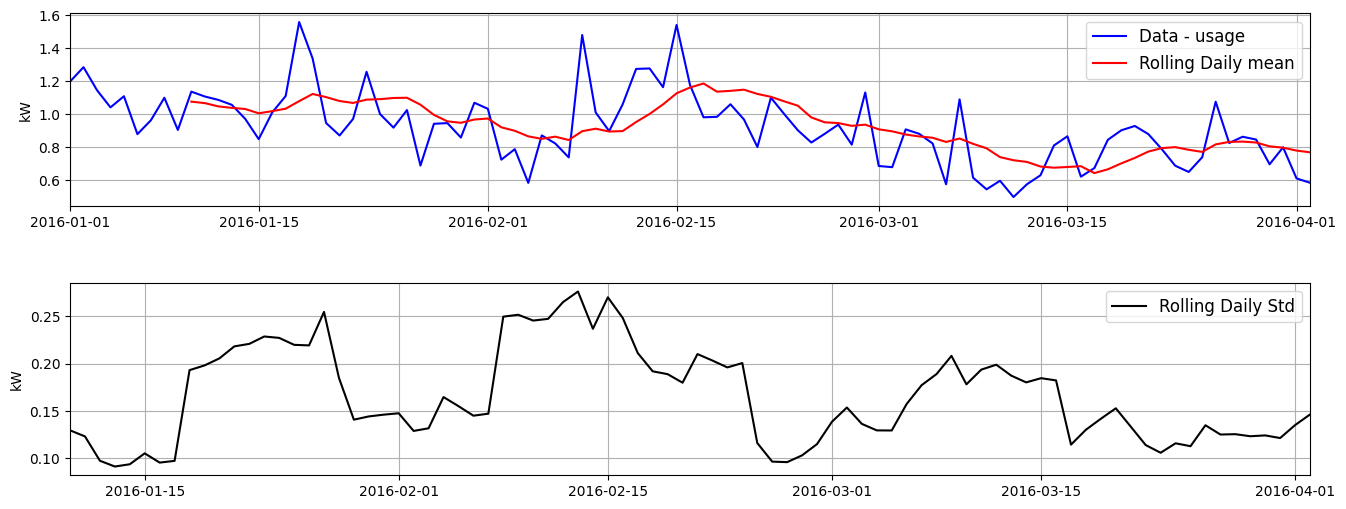

In [ ]:
data_daily = model_data['use'].resample('d').mean()
rolling_MEAN = data_daily.rolling(window=10).mean()
rolling_STD = data_daily.rolling(window=10).std()

#Plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,6))
plt.subplots_adjust(hspace=0.4)
ax1.plot(data_daily, c='blue',label='Data - usage')
ax1.plot(rolling_MEAN, c='red', label='Rolling Daily mean')
ax2.plot(rolling_STD, c='black',label = 'Rolling Daily Std')

ax1.legend(fontsize=12), ax2.legend(fontsize=12)
ax1.set_ylabel('kW'), ax2.set_ylabel('kW')
ax1.margins(x=0), ax2.margins(x=0)
ax1.grid(), ax2.grid()

(None, None)

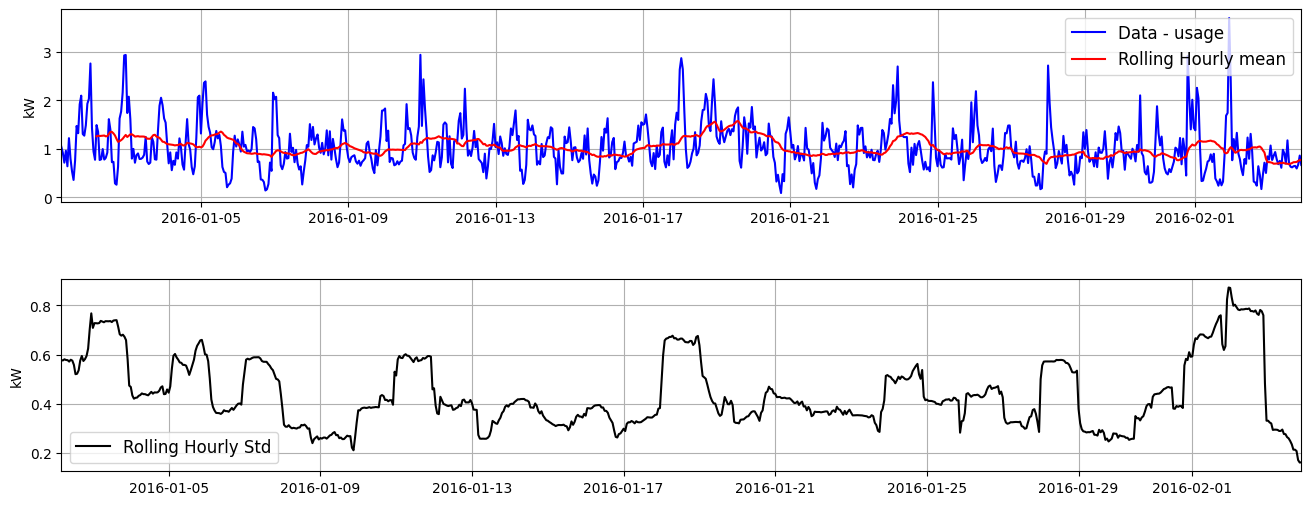

In [ ]:
data_hourly = model_data['use'].resample('h').mean()
rolling_MEAN = data_hourly.rolling(window=24).mean()
rolling_STD = data_hourly.rolling(window=24).std()

#Plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,6))
plt.subplots_adjust(hspace=0.4)
ax1.plot(data_hourly, c='blue',label='Data - usage')
ax1.plot(rolling_MEAN, c='red', label='Rolling Hourly mean')
ax2.plot(rolling_STD, c='black',label = 'Rolling Hourly Std')

ax1.legend(fontsize=12), ax2.legend(fontsize=12)
ax1.set_ylabel('kW'), ax2.set_ylabel('kW')
ax1.margins(x=0), ax2.margins(x=0)
ax1.grid(), ax2.grid()

#### Augmented Dickey-Fuller (ADF) test

In [ ]:
from statsmodels.tsa.stattools import adfuller

result_ADF_test = adfuller(data_daily, autolag='AIC')
Out = pd.Series(result_ADF_test[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
for key1, value1 in result_ADF_test[4].items():
    Out['Critical Value (%s)'%key1] = value1

print('*** DICK-FULLER RESULTS: *** \n\n{}'.format(Out))

*** DICK-FULLER RESULTS: *** 

Test Statistic                -1.537
p-value                        0.515
# of Lags Used                 7.000
Number of Observations Used   85.000
Critical Value (1%)           -3.510
Critical Value (5%)           -2.896
Critical Value (10%)          -2.585
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller

result_ADF_test = adfuller(data_hourly, autolag='AIC')
Out = pd.Series(result_ADF_test[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
for key1, value1 in result_ADF_test[4].items():
    Out['Critical Value (%s)'%key1] = value1

print('*** DICK-FULLER RESULTS (Hourly): *** \n\n{}'.format(Out))

*** DICK-FULLER RESULTS (Hourly): *** 

Test Statistic                 -4.527
p-value                         0.000
# of Lags Used                 21.000
Number of Observations Used   787.000
Critical Value (1%)            -3.439
Critical Value (5%)            -2.865
Critical Value (10%)           -2.569
dtype: float64


> **Interpretation of above ADF test result :**

Based on these results, there's evidence to suggest stationarity:

> Daily Resmapled Rolling

- The test statistic (-2.988) is negative, indicating a tendency towards stationarity.
- The p-value (0.036) is less than 0.05, allowing us to `reject the null hypothesis` of non-stationarity.
- The test statistic (-2.988) is more negative than the critical values at 5% (-2.870) and 10% (-2.571) confidence levels.

> Hourly Resmapled Rolling
 - The results are from an Augmented Dickey-Fuller (ADF) test used to assess the stationarity of an hourly time series dataset. Here's a quick summary:

 - Strong Evidence for Stationarity: The test statistic (-4.527) is very negative, indicating a strong tendency towards stationarity.
 - Highly Significant p-value: The p-value (0.000) is less than 0.05, allowing us to reject the null hypothesis of non-stationarity with very high confidence.
 - Test Statistic Exceeds Critical Values: The test statistic is more negative than the critical values at all confidence levels (1%, 5%, 10%). This further strengthens the evidence for stationarity.

In short, these Hourly resampled ADF test results strongly suggest that the `hourly data might be stationary`. This is a `good sign` for using ARIMA models for forecasting, which typically require stationary data.

However, it's important to note:

  - While these results are promising, a low p-value and negative test statistic aren't a guaranteed confirmation of stationarity.
  - It's advisable to visually inspect the data for trends or seasonality, as these can affect the ADF test results.

## Persistence Model (Neive forecast)
Naive model: $\hat{y}_t=y_{t-1}$ , also known as naive forecast

Naive Model
RMSE: 0.188
MAE: 0.138
MAPE: 0.187
MASE: 0.815
R^2 score: -0.497


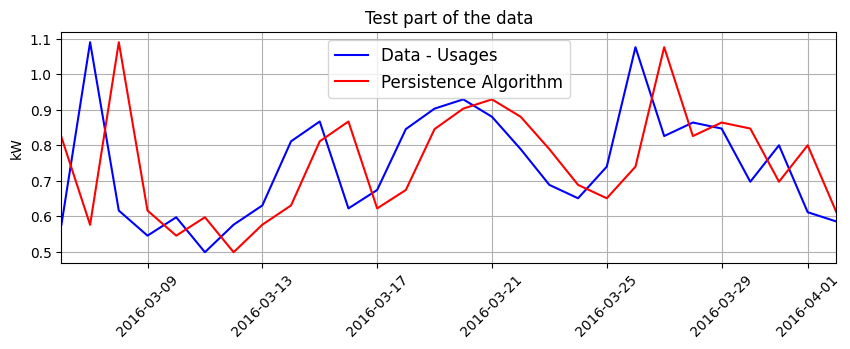

In [ ]:
baseline = data_daily.shift(1)
baseline = baseline.dropna()
data_actual = data_daily.iloc[1:]
size = int(len(data_actual)*0.7)
train = data_daily[:size]
test = data_actual[size:]
baseline_test = baseline.loc[test.index[0]:]

#Plot
plt.figure(figsize=(10,3))
plt.plot(test, c='blue',label='Data - Usages')
plt.plot(baseline_test, c='red', label='Persistence Algorithm')
plt.legend(fontsize=12)
plt.ylabel('kW')
plt.margins(x=0)
plt.title('Test part of the data'), plt.grid(), plt.xticks(rotation=45);

print("Naive Model")
print("="*50)

# calcolo errore
print('RMSE: %.3f' % np.sqrt(mean_squared_error(test, baseline_test)))
MAE = mean_absolute_error(test, baseline_test)
MAPE = np.mean(np.abs(baseline_test - test)/np.abs(test))
MASE = np.mean(np.abs(test - baseline_test ))/(np.abs(np.diff(train)).sum()/(len(train)-1))
print('MAE: %.3f' % MAE)
print('MAPE: %.3f' %MAPE)
print('MASE: %.3f' %MASE)
print('R^2 score: %.3f' % r2_score(test, baseline_test))

## ARIMA

When time series analysis comes in, and a powerful tool within this field is the ARIMA model.


> `ARIMA` stands for `Autoregressive Integrated Moving Average`. It's a statistical approach used to forecast future values in data that exhibits patterns and trends, as opposed to random fluctuations often referred to as `white noise.`

ARIMA's approach to forecasting is unique:

- `Harnessing the Power of the Past`: Unlike some forecasting methods, ARIMA leverages the series' own past values (called lags) and past forecast errors to predict future values. This means the model essentially learns from historical data to identify patterns and make informed predictions about what might happen next.

- `Ensuring Stable Ground`:  For ARIMA to be effective, the data needs to be stationary. This means the statistical properties (like average and variance) of the data remain constant over time. Imagine a bumpy, unpredictable road versus a smooth, straight highway. Differencing the data, which involves subtracting the previous value from the current value, is a common way to achieve stationarity. The number of times differencing is needed (denoted by d in the ARIMA model) depends on the complexity of the data and how "bumpy" the initial data is.

- `Building the Model`: The term "Autoregressive" in ARIMA refers to the use of past values as predictors in a linear regression model. However, for linear regression to be accurate, the predictors shouldn't be correlated. Differencing helps ensure this by making the data stationary.

In short, `ARIMA` combines the power of past data patterns and error corrections to forecast future trends in non-random time series data, offering a valuable tool for making informed decisions based on past experiences.

In [ ]:
# Import the new ARIMA class
from statsmodels.tsa.arima.model import ARIMA

def predict_ts(data, tt_ratio):
    X = data.values
    size = int(len(X) * tt_ratio)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        # Use the new ARIMA class
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('progress:%',round(100*(t/len(test))),'\t predicted=%f, expected=%f' % (yhat, obs), end="\r")
    error = mean_squared_error(test, predictions)
    print('\n Test MSE: %.3f' % error)

    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(train, color='blue', linewidth=2, label="Training Data")
    plt.plot(test, color='red', linewidth=2, label="Testing Data")
    preds = np.append(train, predictions)
    print(preds)

    plt.plot(list(preds), color='green', linewidth=1, label="Predicted Data")
    plt.plot(list(data), color='blue', linewidth=2, label="Original Data")
    plt.axvline(x=int(len(data)*tt_ratio)-1, linewidth=4, color='red')
    plt.legend()
    plt.show()


def one_shot_predict_ts(data, tt_ratio):
    X = data.values
    size = int(len(X) * tt_ratio)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    # Use the new ARIMA class
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    print(model_fit.summary())
    output = model_fit.forecast()
    yhat = output[0]
    prediction = yhat

    # error = mean_squared_error(test, prediction)
    # print('\n Test MSE: %.3f' % error)

    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(train, color='blue', linewidth=2, label="Training Data")
    plt.plot(test, color='red', linewidth=2, label="Testing Data")
    preds = np.append(train, prediction)
    print(preds)

    plt.plot(list(preds), color='green', linewidth=1, label="Predicted Data")
    plt.plot(list(data), color='blue', linewidth=2, label="Original Data")
    plt.axvline(x=int(len(data)*tt_ratio)-1, linewidth=4, color='red')
    plt.legend()
    plt.show()
    return model_fit

#### Split Data, Train & Predict

progress:% 91 	 predicted=0.849239, expected=0.775906
 Test MSE: 0.037
[1.19848203 1.28577852 1.14661676 1.04214307 1.1097006  0.88004354
 0.96419733 1.10059183 0.90535271 1.13759987 1.10811196 1.0877072
 1.05783513 0.9724525  0.8496637  1.01131856 1.11119567 1.55935789
 1.33823432 0.9473726  0.87197784 0.97210115 1.25796457 1.42689929
 0.93545431 0.90252323 1.0171417  0.9052837  1.0123695  0.88225257
 0.98041259 0.88840677 0.97614175 0.84923949]


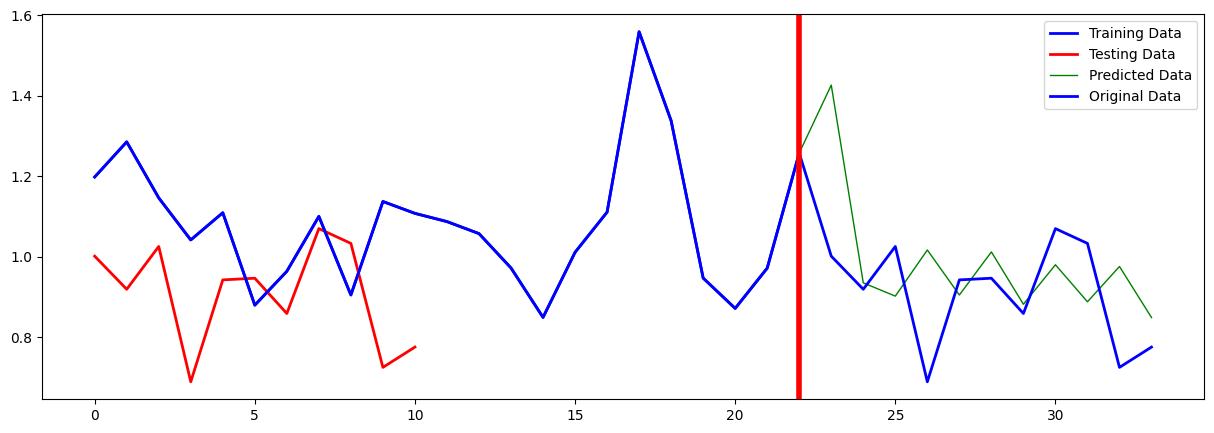

(34,)

In [ ]:
col = 'use'
d_resmpld_data = model_data[col].resample('d').mean() # Daily resampled

tt_ratio = 0.70 # Train to Test ratio
predict_ts(d_resmpld_data, tt_ratio)

d_resmpld_data.shape

progress:% 100 	 predicted=0.811986, expected=0.667525
 Test MSE: 0.187
[1.04412972 0.91816694 0.71473611 0.96001278 0.63983639 1.21941611
 0.79874722 0.53705472 0.35837667 0.75672028 1.47058056 1.32163639
 1.91668861 2.09538972 1.30432333 1.27127833 1.48498639 1.92876333
 2.030315   2.75843861 1.43120028 0.94528333 0.77427111 1.48900639
 1.34940139 0.76965389 0.78405472 0.99446722 0.77856583 0.81464722
 0.922265   1.61103861 1.39428083 0.72421    0.73188083 0.28691
 0.26041472 0.630465   1.62480361 1.76721833 2.15724917 2.92424806
 2.93471028 1.7380025  2.07385972 1.61209667 0.79834861 0.99791611
 0.71365639 0.86919361 0.90486917 0.79055056 0.79340306 0.81798389
 0.87774167 1.24503889 0.7388525  0.68642167 0.71518361 1.23358611
 1.14159167 0.78357028 0.7762525  1.37163611 1.88624389 2.05269694
 1.90010611 1.62760222 1.53868139 1.09611    0.700465   0.92573417
 0.55920722 0.75274194 0.66952417 0.92576833 0.79756722 1.21520806
 1.02252    0.67469417 0.56904778 1.12017306 1.61222833 1.09

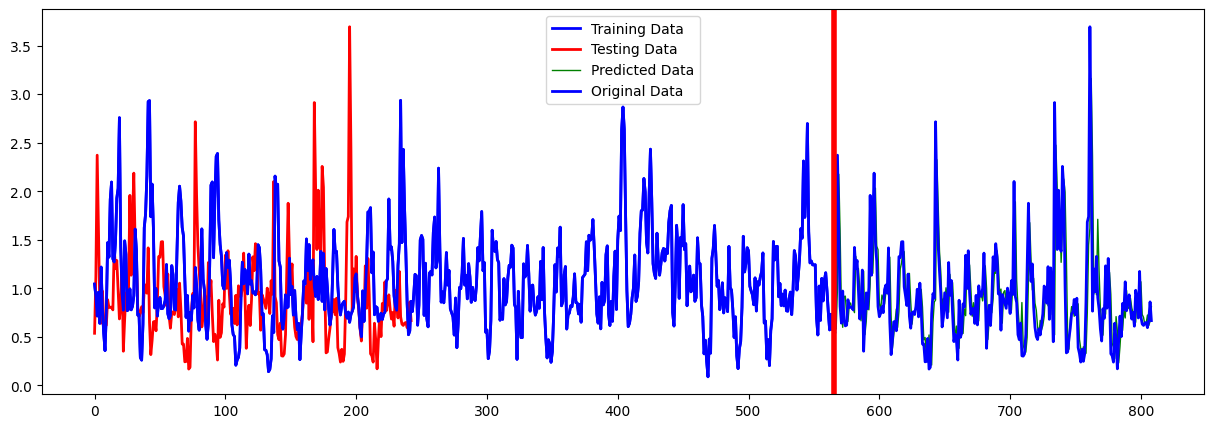

(809,)

In [ ]:
col = 'use'
h_resmpld_data = model_data[col].resample('h').mean() # Hourly resampled

tt_ratio = 0.70 # Train to Test ratio
predict_ts(h_resmpld_data, tt_ratio)

h_resmpld_data.shape

> From the above 2 dataset (Daily resampled vs. Hourly resampled), though both predictions having > 80% accuracy, the hourly resampled model prediction give more accurate result and performance than daily resampled prediction.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  566
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -221.953
Date:                Fri, 31 May 2024   AIC                            455.907
Time:                        01:07:29   BIC                            481.928
Sample:                             0   HQIC                           466.063
                                - 566                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1711      0.035     -4.882      0.000      -0.240      -0.102
ar.L2         -0.0420      0.038     -1.112      0.266      -0.116       0.032
ar.L3         -0.1189      0.035     -3.379      0.0

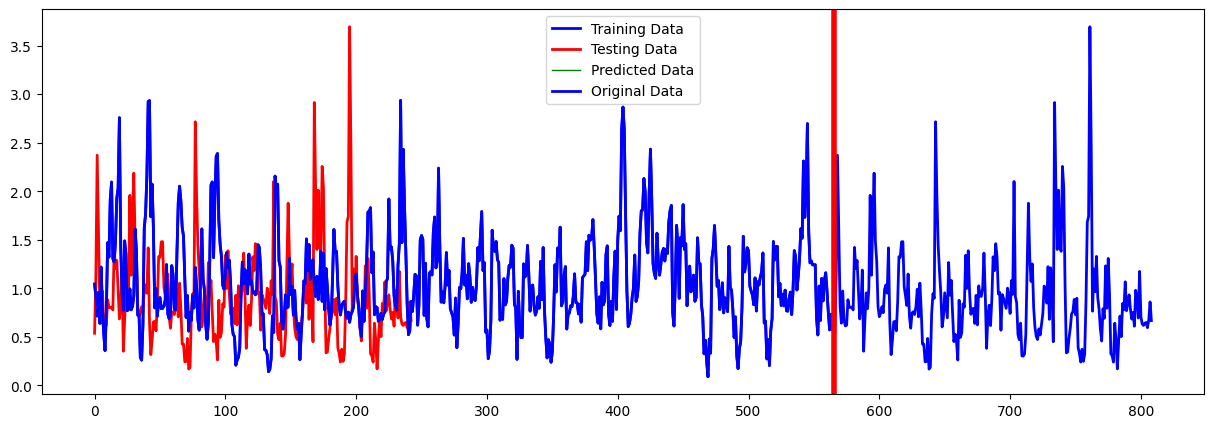

(809,)

In [ ]:
col = 'use'
h_resmpld_data_1 = model_data[col].resample('h').mean() # Hourly resampled

tt_ratio = 0.70 # Train to Test ratio
fitted_model = one_shot_predict_ts(h_resmpld_data_1, tt_ratio)

h_resmpld_data_1.shape

## Residuals

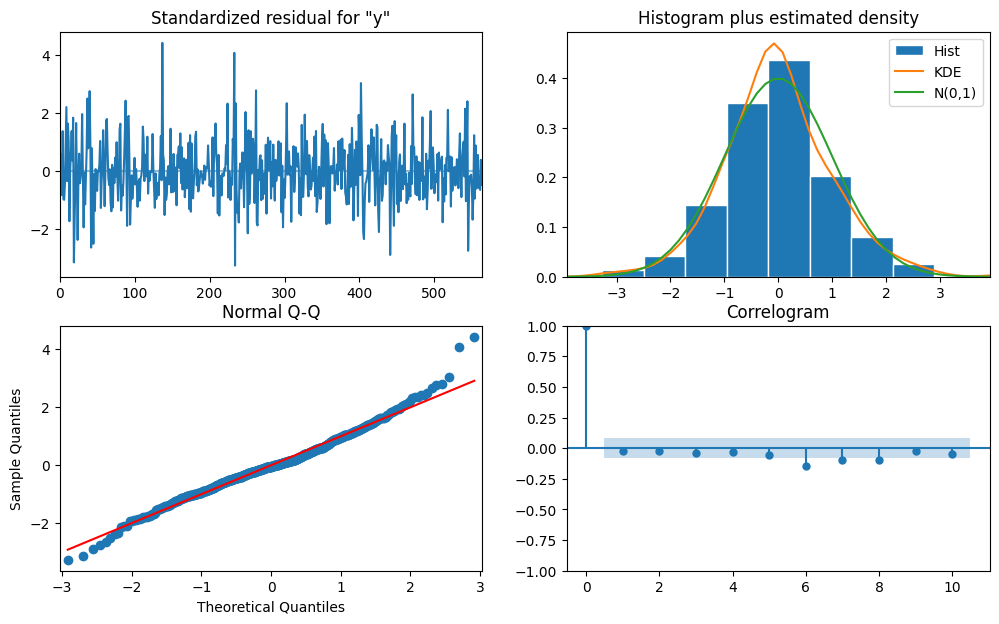

In [ ]:
fitted_model.plot_diagnostics(figsize=(12,7))
plt.show()

## Conclusion

From the above prediction out come, Mean Squared Error (MSE) of 0.187, it gives a better sense of the ARIMA model's accuracy and potentially address the null hypothesis about exceeding 70% accuracy.

> Understanding MSE:

 - MSE is a common metric for evaluating the quality of forecasts. It represents the average squared difference between the predicted values and the actual values. Lower MSE indicates better accuracy.

> Interpreting MSE in this case:

 - The specific interpretation of a 0.187 MSE depends on the range of your data.
If your data typically falls between 0 and 1, then an MSE of 0.187 suggests moderate errors in the predictions.
However, if your data range is much larger (e.g., 0 to 1000), then a 0.187 MSE might indicate a relatively good fit.


> Overall:

 - While the visual inspection of the test prediction and the MSE value provide some insights, it's difficult to definitively reject the null hypothesis based on the limited information available.

> Recommendations:

 - Calculate Data Range: Determine the minimum and maximum values of your data to get a better understanding of the scale and interpret the MSE accordingly.
 - Calculate Additional Metrics: Consider calculating MAE or other accuracy metrics for a more complete picture of the model's performance.
 - Hold-out Validation: If possible, perform a hold-out validation where you split your data into training and testing sets. Fit the model on the training data and evaluate its accuracy on the unseen testing data using metrics like MAE or percentage accuracy.

